In [50]:
#packages
import numpy as np
import os
import copy
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from lime import lime_tabular
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score


In [51]:
# Load the dataset
train_full = pd.read_csv("/Research-Semester/RP/Wind_turbine_code/wine_pipeline/data/base/train-white.csv", sep=",")
test_full = pd.read_csv("/Research-Semester/RP/Wind_turbine_code/wine_pipeline/data/base/test-white.csv", sep=",")

In [52]:
# Prepare the data
target = "quality"
X_train = train_full.drop(columns=[target])
y_train = train_full[target]
X_test = test_full.drop(columns=[target])
y_test = test_full[target]

In [53]:
print("Train data preview:")
print(train_full.head())
print("\nTest data preview:")
print(test_full.head())

Train data preview:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            6.3              0.18         0.36             1.2      0.034   
1            6.8              0.14         0.18             1.4      0.047   
2            6.6              0.24         0.22            12.3      0.051   
3            6.5              0.37         0.30             2.2      0.033   
4            6.9              0.15         0.28             4.4      0.029   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 26.0                 111.0  0.99074  3.16       0.51   
1                 30.0                  90.0  0.99164  3.27       0.54   
2                 35.0                 146.0  0.99676  3.10       0.67   
3                 39.0                 107.0  0.98894  3.22       0.53   
4                 14.0                 107.0  0.99347  3.24       0.46   

   alcohol  quality  
0     11.0        6  
1     11.2        6  


In [54]:
# Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [55]:
# LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    X_train.to_numpy(),
    feature_names=[
        "fixed acidity",
        "volatile acidity",
        "citric acid",
        "residual sugar",
        "chlorides",
        "free sulfur dioxide",
        "total sulfur dioxide",
        "density",
        "pH",
        "sulphates",
        "alcohol"
    ],
    class_names=["3", "4", "5", "6", "7", "8", "9"],  # Adjust based on your dataset
    mode='classification'
)


c:\Users\anwar\anaconda3\envs\wine_env2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


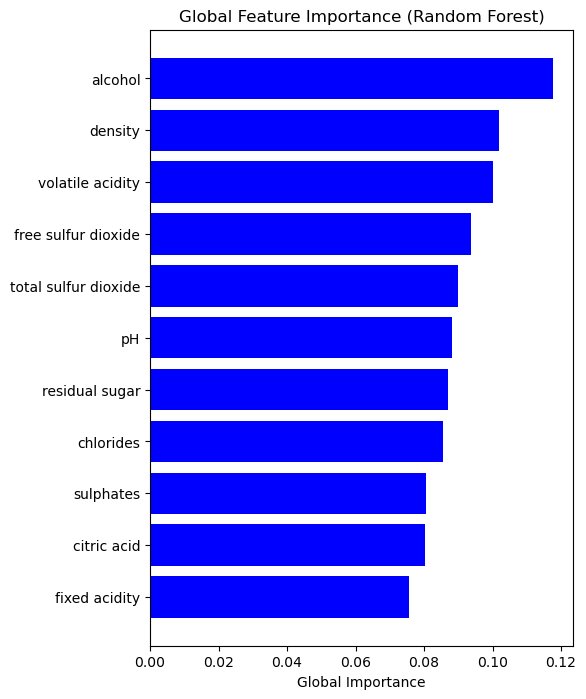

In [56]:
np.random.seed(42)
feature_names = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol"
]

instance_index = 3
instance = X_test.iloc[instance_index].values.reshape(1, -1)

exp = explainer.explain_instance(instance.flatten(), model.predict_proba, labels=[3], num_features=len(X_train.columns))

lime_feature_importances = exp.as_list(label=3) 
lime_feature_names, lime_importances = zip(*lime_feature_importances)

feature_importances = model.feature_importances_

plt.figure(figsize=(12, 8))

# Global Feature Importance
plt.subplot(1, 2, 1)
plt.title("Global Feature Importance (Random Forest)")
plt.barh(np.array(feature_names)[sorted_indices], feature_importances[sorted_indices], color='blue')
plt.xlabel("Global Importance")
plt.gca().invert_yaxis()

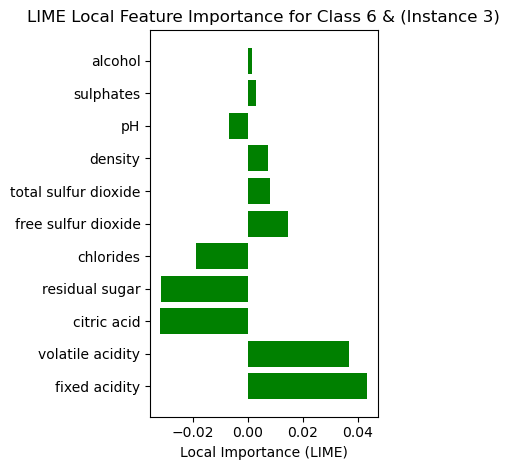

In [57]:
# Local Feature Importance (LIME)
plt.subplot(1, 2, 2)
plt.title(f"LIME Local Feature Importance for Class 6 & (Instance {instance_index})")
plt.barh(feature_names, lime_importances, color='green')
plt.xlabel("Local Importance (LIME)")

plt.tight_layout()
plt.show()


In [47]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(X_train.values, feature_names=feature_names,mode='classification')                            
num_instances = 1400  
feature_importances = []

for i in range(num_instances):
    instance = X_test.iloc[i].values.reshape(1, -1)
    exp = explainer.explain_instance(instance.flatten(), model.predict_proba, labels=[3],  num_features=len(X_train.columns))
    local_importance = dict(exp.as_list(label=3))  
    feature_importances.append(local_importance)

# list of local importances to a DataFrame
df_importance = pd.DataFrame(feature_importances)

# mean absolute importance for each feature (global importance)
global_feature_importance = df_importance.abs().mean(axis=0)

# top 10 features by importance
top_features = global_feature_importance.sort_values(ascending=False).head(10)

# Step 6: Plot clean global feature importance using LIME
plt.figure(figsize=(10, 6))
top_features.sort_values().plot(kind='barh', color='blue')
plt.xlabel("Mean Absolute Importance")
plt.title("Global Feature Importance using LIME (Top 10 Features)")
plt.show()


c:\Users\anwar\anaconda3\envs\wine_env2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\anwar\anaconda3\envs\wine_env2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\anwar\anaconda3\envs\wine_env2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\anwar\anaconda3\envs\wine_env2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\anwar\anaconda3\envs\wine_env2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  

KeyboardInterrupt: 

In [37]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.67


In [38]:
def calculate_stability_score(instance, model, explainer, epsilon=0.1, num_samples=200):
    # Original explanation
    exp = explainer.explain_instance(instance, model.predict_proba, num_features=len(feature_names))
    phi_original = np.array([imp for _, imp in exp.as_list()])

    # perturbed samples
    perturbations = np.random.normal(loc=0, scale=epsilon, size=(num_samples, instance.shape[0]))
    perturbed_samples = np.clip(instance + perturbations, X_train.values.min(axis=0), X_train.values.max(axis=0))

    max_stability = 0
    for perturbed_instance in perturbed_samples:
        # Explanation for perturbed instance
        exp_perturbed = explainer.explain_instance(perturbed_instance, model.predict_proba, num_features=len(feature_names))
        phi_perturbed = np.array([imp for _, imp in exp_perturbed.as_list()])

        # L2 norms
        phi_diff = np.linalg.norm(phi_original - phi_perturbed, ord=2)
        input_diff = np.linalg.norm(instance - perturbed_instance, ord=2)

        # Stability score
        stability = phi_diff / (input_diff + 1e-8) 
        max_stability = max(max_stability, stability)

    return max_stability

num_instances = 0  
stability_scores_dt_lime = []

for i in range(num_instances):
    instance = X_test.iloc[i].values
    score = calculate_stability_score(instance, model, explainer)
    stability_scores_dt_lime.append(score)

print("Stability scores for RF + LIME:", stability_scores_dt_lime)


c:\Users\anwar\anaconda3\envs\wine_env2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\anwar\anaconda3\envs\wine_env2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\anwar\anaconda3\envs\wine_env2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\anwar\anaconda3\envs\wine_env2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\anwar\anaconda3\envs\wine_env2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  

Stability scores for RF + LIME: [0.29861963891612847, 0.3355559741065237, 0.3345744119679367, 0.2733183800795793, 0.2383166891240612, 0.2875424752549141, 0.2779214305867673, 0.4777167371780509, 0.20767871001012903, 0.16876736712324356, 0.2712504122370445, 0.35966464098227474, 0.30903010115620977, 0.34443131426912316, 0.40422474171296713, 0.33545267548478225, 0.24655210369952613, 0.29182141524768723, 0.3671661364842336, 0.4088179060419628, 0.3155342192596477, 0.21403448860131988, 0.2895775727922843, 0.3577361243949719, 0.3878213651586667, 0.41371107818839437, 0.286960029629731, 0.31451589304000266, 0.2846058436387873, 0.29679737652121724, 0.28895179045336583, 0.38942890537933766, 0.3060707678995499, 0.4007052161681893, 0.3726520944603896, 0.2345485032675912, 0.28184443889715793, 0.3053309405024547, 0.26701136066676284, 0.349006331705881, 0.2898578834053622, 0.21916038506452729, 0.47578838329450496, 0.21311017661094087, 0.2887452559626432, 0.4038466673073072, 0.4302381732713781, 0.315021

In [49]:
# function to get feature importance vector using LIME
def get_lime_feature_importance(instance, model, explainer):
    exp = explainer.explain_instance(instance.flatten(), model.predict_proba, num_features=len(feature_names))
    phi = np.array([imp for _, imp in exp.as_list()])
    return phi

# Example usage for 10 instances
lime_feature_importances = []
for i in range(5): 
    instance = X_test.iloc[i].values.reshape(1, -1)
    phi = get_lime_feature_importance(instance, model, explainer)
    lime_feature_importances.append(phi)

lime_feature_importances = np.array(lime_feature_importances)

print("consistancy scores for RF + LIME:", lime_feature_importances)


c:\Users\anwar\anaconda3\envs\wine_env2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\anwar\anaconda3\envs\wine_env2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\anwar\anaconda3\envs\wine_env2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\anwar\anaconda3\envs\wine_env2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


consistancy scores for RF + LIME: [[ 3.52342222e-02  2.94733047e-02  1.57164095e-02 -1.33764390e-02
   1.25968428e-02  9.52288794e-03 -6.08600570e-03 -5.80837686e-03
   2.45553817e-03  1.00315787e-03 -2.70265839e-05]
 [-1.44640639e-02  1.11355179e-02  1.06198713e-02  1.04743614e-02
  -9.45972143e-03  8.31557543e-03  6.97533580e-03 -4.77237884e-03
   2.78835583e-03  2.72016074e-03  3.34348165e-04]
 [-2.02342502e-02  1.70649021e-02 -1.14703476e-02 -1.04221096e-02
  -1.02584210e-02  9.55471752e-03  8.80221982e-03 -6.09847761e-03
   3.87500820e-03 -3.64620629e-03 -1.29332956e-04]
 [ 3.49073222e-02 -2.19152235e-02  1.60500351e-02 -9.56427035e-03
  -7.24344461e-03 -6.55658248e-03  6.27226302e-03  4.79303257e-03
  -4.07640448e-03 -2.36845343e-03 -9.60042488e-04]
 [ 2.71310305e-02 -1.94572317e-02 -1.16551585e-02  1.02641784e-02
  -9.66508255e-03 -7.85799749e-03 -5.23932365e-03 -5.00096638e-03
  -3.92756540e-03 -1.73261995e-03  6.00768603e-04]]


c:\Users\anwar\anaconda3\envs\wine_env2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
